In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Load the data (replace with your actual file paths)
crop_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=0)
region_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=2)

# Remove unnecessary spaces in column names
crop_data.columns = crop_data.columns.str.strip()
region_data.columns = region_data.columns.str.strip()

# Handling missing values
# Optionally fill or drop missing values depending on your preference
crop_data.fillna(crop_data.median(), inplace=True)

# Identifying numerical columns
numerical_features = crop_data.select_dtypes(include=[np.number]).columns.tolist()

# Outlier removal using Z-score (for normally distributed features)
z_scores = np.abs(stats.zscore(crop_data[numerical_features]))
crop_data = crop_data[(z_scores < 3).all(axis=1)]

# Feature scaling only for numerical columns
scaler = StandardScaler()
crop_data[numerical_features] = scaler.fit_transform(crop_data[numerical_features])

# Encoding categorical data (e.g., converting 'Crop' column to numerical labels)
if 'Crop' in crop_data.columns:
    crop_data['Crop'] = crop_data['Crop'].astype('category').cat.codes

# Merge with region data if necessary
# Example: Assuming 'District' is a common column
crop_data = crop_data.merge(region_data, on='District', how='left')

# Save the cleaned and processed dataset for model input
crop_data.to_csv('cleaned_crop_data.csv', index=False)


TypeError: could not convert string to float: 'Mango'

In [9]:
import pandas as pd

# Load the crop and region data from the Excel file
crop_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=0)
region_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=2)

In [10]:
import numpy as np

# General function to handle both single values and ranges
def convert_range(value):
    if isinstance(value, str) and '-' in value:
        # If it's a range like '40-60', convert to the average
        value_range = value.split('-')
        return (float(value_range[0]) + float(value_range[1])) / 2
    else:
        # If it's a single value, attempt to convert it to float
        try:
            return float(value)
        except ValueError:
            return np.nan  # Handle non-convertible values

# Apply the conversion function to the 'pH', 'P', and 'K' columns
crop_data['pH'] = crop_data['pH'].apply(convert_range)
crop_data['P'] = crop_data['P'].apply(convert_range)
crop_data['K'] = crop_data['K'].apply(convert_range)

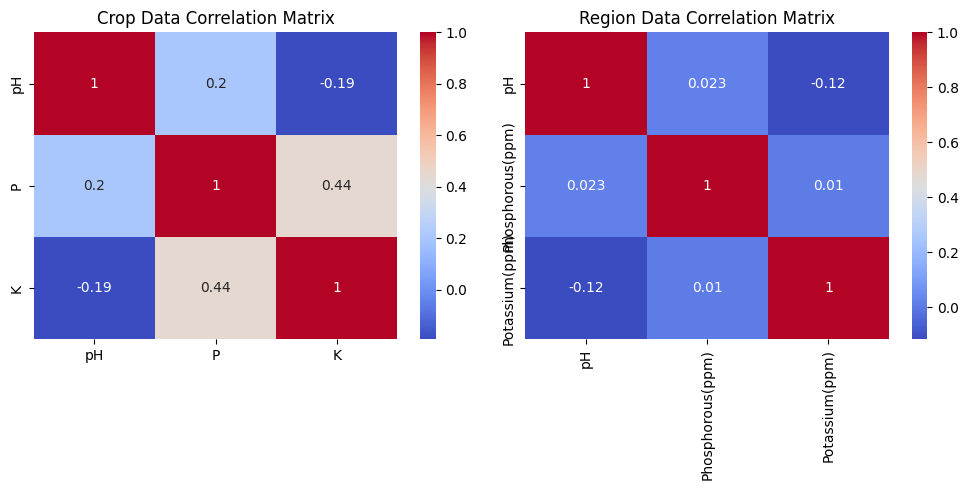

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
crop_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=0)
region_data = pd.read_excel('datasets/crop_recommendation_new.xlsx', sheet_name=2)

# Function to handle ranges (like '6.0-7.0') and single values
def convert_range(value):
    if isinstance(value, str) and '-' in value:
        # Convert range (e.g., '40-60') to the average of the range
        value_range = value.split('-')
        return (float(value_range[0]) + float(value_range[1])) / 2
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan  # Return NaN for non-convertible values

# Apply the conversion function to the crop data (pH, P, K)
crop_data['pH'] = crop_data['pH'].apply(convert_range)
crop_data['P'] = crop_data['P'].apply(convert_range)
crop_data['K'] = crop_data['K'].apply(convert_range)

# Apply the conversion function to the region data (pH, Phosphorous, Potassium)
region_data['pH'] = region_data['pH'].apply(convert_range)
region_data['Phosphorous(ppm)'] = region_data['Phosphorous(ppm)'].apply(convert_range)
region_data['Potassium(ppm)'] = region_data['Potassium(ppm)'].apply(convert_range)

# Now that the data is cleaned, compute the correlation matrices
crop_corr = crop_data[['pH', 'P', 'K']].corr()
region_corr = region_data[['pH', 'Phosphorous(ppm)', 'Potassium(ppm)']].corr()

# Plot the correlation matrices
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.heatmap(crop_corr, annot=True, cmap='coolwarm')
plt.title("Crop Data Correlation Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(region_corr, annot=True, cmap='coolwarm')
plt.title("Region Data Correlation Matrix")

plt.tight_layout()
plt.show()


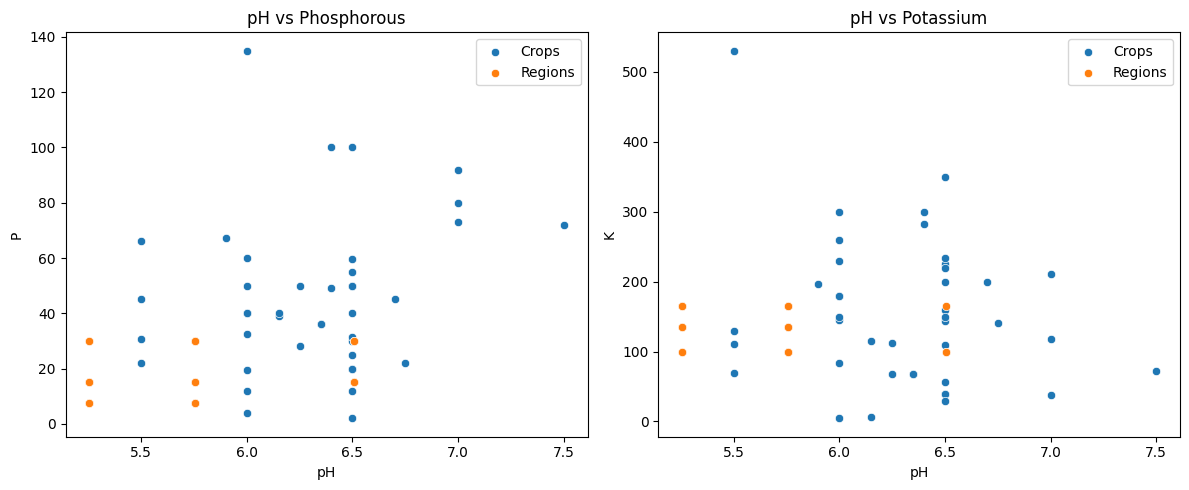

In [13]:
# Scatter plot for pH vs Phosphorous and pH vs Potassium for both datasets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(data=crop_data, x='pH', y='P', label='Crops')
sns.scatterplot(data=region_data, x='pH', y='Phosphorous(ppm)', label='Regions')
plt.title('pH vs Phosphorous')

plt.subplot(1, 2, 2)
sns.scatterplot(data=crop_data, x='pH', y='K', label='Crops')
sns.scatterplot(data=region_data, x='pH', y='Potassium(ppm)', label='Regions')
plt.title('pH vs Potassium')

plt.tight_layout()
plt.show()


In [15]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Define the imputer (you can change the strategy to 'median' or 'most_frequent')
imputer = SimpleImputer(strategy='mean')

# Select the relevant columns for clustering
X = crop_data[['pH', 'P', 'K']]

# Impute the missing values
X_imputed = imputer.fit_transform(X)

# Now run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Define your k value
crop_data['Cluster'] = kmeans.fit_predict(X_imputed)

# Check the first few rows with cluster labels
print(crop_data.head())


              Crop Crop type  Crop suitability Altitude (masl)  \
0            Mango     Fruit               NaN        680-1400   
1  Banana(Robusta)     Fruit               NaN     1,400–2,300   
2           Citrus     Fruit               NaN        900-2500   
3            Apple     Fruit               NaN        120-3500   
4        Pineapple     Fruit               NaN           >1100   

  Annual rainfall (mm) temperature (C)    pH  \
0             890-1015            20-26  6.5   
1            1500-2500           26-30   7.0   
2             900-1200            23-30  6.5   
3              500-700            15-24  6.5   
4             700-1000            20-30  5.5   

                                Soil type    N     P      K  \
0   well-draining, sandy loam, loamy soil  100  25.0  110.0   
1                       loamy - loam clay  322  73.0  118.0   
2               loamy or sandy loam soils   22  12.0   57.0   
3                well-drained, loamy soil   18   2.0   40.0   

In [17]:
from sklearn.cluster import KMeans

# Drop rows with missing values in the 'pH', 'P', and 'K' columns
crop_data_clean = crop_data[['pH', 'P', 'K']].dropna()

# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Define your k value
crop_data_clean['Cluster'] = kmeans.fit_predict(crop_data_clean)

# Check the first few rows with cluster labels
print(crop_data_clean.head())


    pH     P      K  Cluster
0  6.5  25.0  110.0        1
1  7.0  73.0  118.0        1
2  6.5  12.0   57.0        1
3  6.5   2.0   40.0        1
4  5.5  45.0  530.0        2


In [18]:
from sklearn.impute import SimpleImputer

# Define the imputer (use 'mean' or another strategy)
imputer = SimpleImputer(strategy='mean')

# Impute missing values in 'pH' for both datasets
crop_data['pH'] = imputer.fit_transform(crop_data[['pH']])
region_data['pH'] = imputer.fit_transform(region_data[['pH']])

# Perform the merge_asof after sorting by 'pH'
crop_region_match = pd.merge_asof(crop_data.sort_values('pH'),
                                  region_data.sort_values('pH'),
                                  left_on='pH', right_on='pH')

# Check the merged result
print(crop_region_match.head())


             Crop      Crop type  Crop suitability Altitude (masl)  \
0          Coffee  Beverage Crop               NaN       1500-2000   
1        Soyabean         Legume               NaN          0-2200   
2             Tea  Beverage Crop               NaN       1600-2800   
3       Pineapple          Fruit               NaN           >1100   
4  Sweat potatoes     Tuber/Root               NaN       1000-2100   

  Annual rainfall (mm) temperature (C)    pH                       Soil type  \
0            1500-2000            18-26  5.5                   volcanic soil   
1             400-1200            15-25  5.5   Well drained sand, clay loams   
2            1500-2500            18-25  5.5                   volcanic soil   
3             700-1000            20-30  5.5   sandy loam soil, well drained   
4             750-1000            25-30  5.9                      Loamy soil   

         N      P  ...  Magnessium(%) Magnessium(ppm) Manganese(ppm)  \
0  150-275  66.00  ...    

In [19]:
# Drop rows with missing values in the 'pH' column for both datasets
crop_data_clean = crop_data.dropna(subset=['pH'])
region_data_clean = region_data.dropna(subset=['pH'])

# Perform the merge_asof after sorting by 'pH'
crop_region_match = pd.merge_asof(crop_data_clean.sort_values('pH'),
                                  region_data_clean.sort_values('pH'),
                                  left_on='pH', right_on='pH')

# Check the merged result
print(crop_region_match.head())


             Crop      Crop type  Crop suitability Altitude (masl)  \
0          Coffee  Beverage Crop               NaN       1500-2000   
1        Soyabean         Legume               NaN          0-2200   
2             Tea  Beverage Crop               NaN       1600-2800   
3       Pineapple          Fruit               NaN           >1100   
4  Sweat potatoes     Tuber/Root               NaN       1000-2100   

  Annual rainfall (mm) temperature (C)    pH                       Soil type  \
0            1500-2000            18-26  5.5                   volcanic soil   
1             400-1200            15-25  5.5   Well drained sand, clay loams   
2            1500-2500            18-25  5.5                   volcanic soil   
3             700-1000            20-30  5.5   sandy loam soil, well drained   
4             750-1000            25-30  5.9                      Loamy soil   

         N      P  ...  Magnessium(%) Magnessium(ppm) Manganese(ppm)  \
0  150-275  66.00  ...    

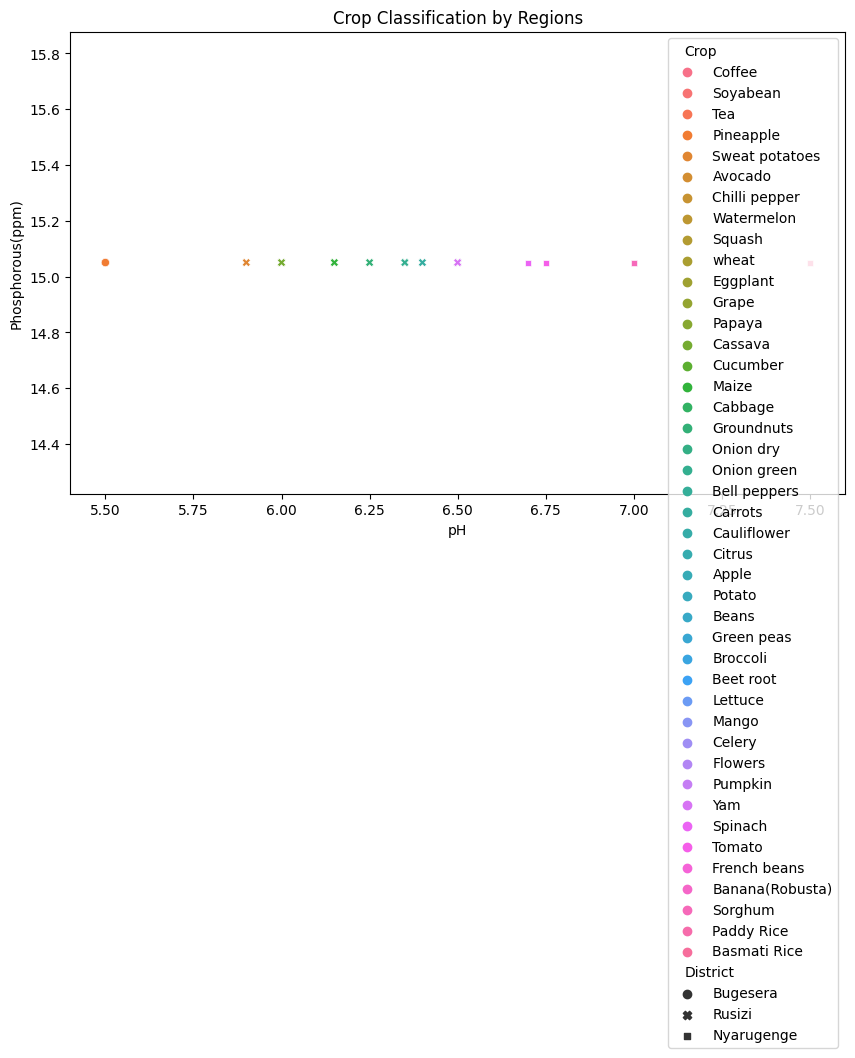

In [20]:
# Visualizing which regions are best suited for which crops
plt.figure(figsize=(10, 6))
sns.scatterplot(data=crop_region_match, x='pH', y='Phosphorous(ppm)', hue='Crop', style='District')
plt.title('Crop Classification by Regions')
plt.show()
